# Lexical Hybrid Feature Selection (XGB)

In [21]:
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import filter_feature_selection
import scipy.stats as stats

The first stage of this feature selection technique utilizes the filter-based methods to reduce the featureset.

The respective F-score of the features are then calculated using ANOVA. The higher the F-score, the better a feature is.

In [22]:
anova_features, anova_f_scores = filter_feature_selection.anova_feature_selection('final_unbalanced_with_lexical.csv')

c:\Users\Eri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [15 51 55] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Eri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [23]:
anova_f_scores = [i for i in anova_f_scores if str(i) != 'nan']
anova_f_scores = np.array(anova_f_scores)

Using the computed F-scores, the Z-scores are obtained so that the features with F-scores belonging in the upper 50 percentile are selected.

In [24]:
anova_z_scores = stats.zscore(anova_f_scores)

In [25]:
percentile = []
for z_score in anova_z_scores:
    percentile.append(stats.norm.cdf(z_score))

In [26]:
feature_percentile_dict = {}
print('Feature Percentile: ')
for i in range(len(percentile)):
    print(anova_features[i], ': ', percentile[i])
    if percentile[i] > 0.50:
        feature_percentile_dict[anova_features[i]] = percentile[i]

Feature Percentile: 
url_host_length :  0.9999999154054002
url_is_https :  0.9851449114414272
url_ip_in_domain :  0.984454144298416
has_php_in_string :  0.9801919264023486
url_number_of_parameters :  0.9723791520118684
has_exe_in_string :  0.9714855635190668
url_has_port :  0.969543544206523
url_num_equal :  0.9694476816886433
url_num_ampersand :  0.9566690361059697
url_is_digits_in_domain :  0.8696903322040741
url_path_length :  0.7590513353039839
url_num_question_mark :  0.7087181178585258
url_query_length :  0.6018388999372104
url_string_entropy :  0.5361937075903936
url_num_periods :  0.5304886673539473
url_num_forward_slash :  0.45782323516996204
url_domain_len :  0.44680580887724913
url_number_of_subdirectories :  0.440767844819599
has_linkeq_in_string :  0.4270448461906734
url_num_of_hyphens :  0.42440112619347753
url_number_of_letters :  0.4215869349576995
url_domain_entropy :  0.4129542634720332
url_length :  0.40423422463569514
url_num_underscore :  0.36256077818091026
has_jp

Shown below are the features with F-scores that belong in the upper 50 percentile.

In [27]:
feature_percentile_dict

{'url_host_length': 0.9999999154054002,
 'url_is_https': 0.9851449114414272,
 'url_ip_in_domain': 0.984454144298416,
 'has_php_in_string': 0.9801919264023486,
 'url_number_of_parameters': 0.9723791520118684,
 'has_exe_in_string': 0.9714855635190668,
 'url_has_port': 0.969543544206523,
 'url_num_equal': 0.9694476816886433,
 'url_num_ampersand': 0.9566690361059697,
 'url_is_digits_in_domain': 0.8696903322040741,
 'url_path_length': 0.7590513353039839,
 'url_num_question_mark': 0.7087181178585258,
 'url_query_length': 0.6018388999372104,
 'url_string_entropy': 0.5361937075903936,
 'url_num_periods': 0.5304886673539473}

Chi2 is used to determine the significance of categorical features. The higher the Chi2 statistics, the better a feature is and the lower its P value, the more significant the observation. Based on the results, both categorical features are to be retained.

In [28]:
filter_feature_selection.chi2_feature_selection('final_unbalanced_with_lexical.csv')

Chi2 Statistics: 
[88439618.85652827  6900658.46790684]
Chi2 P Values: 
[0. 0.]
get_tld       8.843962e+07
url_scheme    6.900658e+06
get_tld       0.0
url_scheme    0.0
dtype: float64


Features with high correlation are to be weeded out. This is to eliminate redundancy in the featureset.

In [29]:
features_high_correlation = filter_feature_selection.correlation_feature_selection('final_unbalanced_with_lexical.csv')

features_high_correlation

[['url_num_forward_slash', 'url_number_of_subdirectories'],
 ['url_num_equal', 'url_num_ampersand', 'url_number_of_parameters'],
 ['url_number_of_letters', 'url_length'],
 ['url_domain_len', 'url_domain_entropy'],
 ['url_num_close_parenthesis', 'url_num_open_parenthesis']]

In [36]:
to_remove = []

for feature in feature_percentile_dict:
    for high_corr_group in features_high_correlation:
        if feature in high_corr_group:
            for ref_feature in high_corr_group:
                if (ref_feature != feature) and (ref_feature in feature_percentile_dict.keys()):
                    if feature_percentile_dict[feature] >= feature_percentile_dict[ref_feature]:
                        print('Removed: ', ref_feature)
                        to_remove.append(ref_feature)
                        high_corr_group.remove(ref_feature)
                        #feature_percentile_dict.pop(ref_feature, None)
                    else:
                        print('Removed: ', feature)
                        to_remove.append(feature)
                        high_corr_group.remove(feature)
                        #feature_percentile_dict.pop(feature, None)

print(to_remove)

{'url_host_length': 0.9999999154054002, 'url_is_https': 0.9851449114414272, 'url_ip_in_domain': 0.984454144298416, 'has_php_in_string': 0.9801919264023486, 'url_number_of_parameters': 0.9723791520118684, 'has_exe_in_string': 0.9714855635190668, 'url_has_port': 0.969543544206523, 'url_is_digits_in_domain': 0.8696903322040741, 'url_path_length': 0.7590513353039839, 'url_num_question_mark': 0.7087181178585258, 'url_query_length': 0.6018388999372104, 'url_string_entropy': 0.5361937075903936, 'url_num_periods': 0.5304886673539473}


In [ ]:
for feature in to_remove:
    feature_percentile_dict.pop(feature, None)

In [39]:
final_anova_features = [key for key in feature_percentile_dict.keys()]

final_anova_features

['url_host_length',
 'url_is_https',
 'url_ip_in_domain',
 'has_php_in_string',
 'url_number_of_parameters',
 'has_exe_in_string',
 'url_has_port',
 'url_is_digits_in_domain',
 'url_path_length',
 'url_num_question_mark',
 'url_query_length',
 'url_string_entropy',
 'url_num_periods']

After combining the results of ANOVA and Chi2 and removing the highly correlated features, the final featureset is seen below.

In [51]:
final_features = final_anova_features + ['get_tld'] + ['url_scheme'] # ADD CATEGORICAL IF GOOD CHI2 SCORE AND SIGNIFICANT BASED ON P VALUE | WILL AUTOMATE LATER

final_features

['url_host_length',
 'url_is_https',
 'url_ip_in_domain',
 'has_php_in_string',
 'url_number_of_parameters',
 'has_exe_in_string',
 'url_has_port',
 'url_is_digits_in_domain',
 'url_path_length',
 'url_num_question_mark',
 'url_query_length',
 'url_string_entropy',
 'url_num_periods',
 'get_tld',
 'url_scheme']

Once the featureset has been reduced through the filter-based method, the reduced featureset will be ran through a forward feature selection selection algorithm with the respective machine learning model (XGB) for further reduction.

The URL dataset with generated lexical features are read from a csv file. These are then displayed for visualization purposes.

In [42]:
dataset = pd.read_csv('final_unbalanced_with_lexical.csv')

In [53]:
features = dataset.iloc[:, 1:]
url_type = dataset.iloc[:, 0]

features = features.drop(columns = [col for col in features if col not in final_features])

features

,url_ip_in_domain,url_is_digits_in_domain,url_query_length,url_number_of_parameters,url_string_entropy,url_is_https,url_path_length,url_host_length,get_tld,url_has_port,url_num_periods,url_num_question_mark,has_exe_in_string,has_php_in_string,url_scheme
0,0,0,0,0,3.375000,0,16,0,0,0,2,0,0,0,0
1,0,1,0,0,4.079143,0,35,0,0,0,2,0,0,0,0
2,0,0,0,0,3.708093,0,31,0,0,0,2,0,0,0,0
3,0,0,49,4,4.660343,0,10,21,283,0,3,1,0,1,27
4,0,0,194,3,4.980518,0,10,23,459,0,2,1,0,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684177,0,0,0,0,4.151859,0,28,16,320,0,3,0,1,0,27
684178,0,0,0,0,4.298701,0,29,17,320,0,2,0,0,0,27
684179,0,0,0,0,4.187850,0,30,12,396,0,2,0,0,0,27
684180,0,1,0,0,4.778025,0,69,10,320,0,1,0,0,0,27


A forward feature selection algorithm is then ran on the dataset using XGB with a scoring that's dependent on accuracy and a cross validatoin of 5.

In [57]:
forward_feature_selection = SequentialFeatureSelector(XGBClassifier(), k_features = 15, forward = True,
                                                      floating = False, verbose = 10, scoring = 'accuracy', n_jobs = 1).fit(features, url_type)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   22.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  4.7min

[2024-03-18 00:35:22] Features: 1/15 -- score: 0.776517087933838[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   24.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  4.7min

[2024-03-18 00:40:43] Features: 2/15 -- score: 0.8280886212914279[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   23.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  4.8min

[2024-03-18 00:46:00] Features: 3/15 -- score: 0.853714656161897[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.4s
[Parallel(n

Once all iterations have finished, the results of each iteration are displayed.

In [58]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame.from_dict(forward_feature_selection.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(14,)","[0.7760319879731903, 0.7776292986448959, 0.7767186929059874, 0.7749230046458214, 0.7772824554992953]",0.776517,"(url_scheme,)",0.001238,0.000963,0.000482
2,"(6, 14)","[0.8280228843463554, 0.829025118493308, 0.8269666440465626, 0.8274886464477736, 0.8289398131231404]",0.828089,"(url_path_length, url_scheme)",0.001032,0.000803,0.000402
3,"(6, 8, 14)","[0.8542584511306454, 0.8540392124109996, 0.8534739259800596, 0.8532442449235267, 0.8535574463642532]",0.853715,"(url_path_length, get_tld, url_scheme)",0.000483,0.000376,0.000188
4,"(6, 7, 8, 14)","[0.8690518447372267, 0.869083164554319, 0.8680273529258234, 0.8679020723495328, 0.8687268361434463]",0.868558,"(url_path_length, url_host_length, get_tld, url_scheme)",0.000645,0.000502,0.000251
5,"(4, 6, 7, 8, 14)","[0.8763493621197253, 0.8757229657778799, 0.8751265855822937, 0.8745523829409615, 0.875805188703868]",0.875511,"(url_string_entropy, url_path_length, url_host_length, get_tld, url_scheme)",0.000793,0.000617,0.000308
6,"(4, 6, 7, 8, 10, 14)","[0.8875096569436034, 0.888344852066064, 0.8865166779767187, 0.8870073602338571, 0.886433157592525]",0.887162,"(url_string_entropy, url_path_length, url_host_length, get_tld, url_num_periods, url_scheme)",0.000907,0.000706,0.000353
7,"(2, 4, 6, 7, 8, 10, 14)","[0.8898690831645543, 0.8913411145678909, 0.889366811087331, 0.8899723338727358, 0.8894503314715247]",0.89,"(url_query_length, url_string_entropy, url_path_length, url_host_length, get_tld, url_num_periods, url_scheme)",0.000912,0.00071,0.000355
8,"(2, 4, 6, 7, 8, 10, 13, 14)","[0.8925417075564279, 0.8935439417033805, 0.8918411024690713, 0.8930103878477841, 0.8926867463590332]",0.892725,"(url_query_length, url_string_entropy, url_path_length, url_host_length, get_tld, url_num_periods, has_php_in_string, url_scheme)",0.00072,0.00056,0.00028
9,"(2, 4, 6, 7, 8, 10, 12, 13, 14)","[0.8937109807278726, 0.8946505752406406, 0.8927598266952028, 0.8943258338988359, 0.8942214334185937]",0.893934,"(url_query_length, url_string_entropy, url_path_length, url_host_length, get_tld, url_num_periods, has_exe_in_string, has_php_in_string, url_scheme)",0.000848,0.00066,0.00033
10,"(2, 3, 4, 6, 7, 8, 10, 12, 13, 14)","[0.8939824191426722, 0.8952874115215167, 0.8939395521219398, 0.8946703554836353, 0.8947225557237564]",0.89452,"(url_query_length, url_number_of_parameters, url_string_entropy, url_path_length, url_host_length, get_tld, url_num_periods, has_exe_in_string, has_php_in_string, url_scheme)",0.00065,0.000506,0.000253


In [59]:
all_iterations = pd.DataFrame.from_dict(forward_feature_selection.get_metric_dict()).T
all_iterations_series = pd.Series(all_iterations['avg_score'])
all_iterations_list = all_iterations_series.to_list()

prev = all_iterations_list[0]
for accuracy in all_iterations_list[1:]:
    if accuracy > prev*1.001:
        prev = accuracy
        pass
    else:
        print('Plateus at: ', all_iterations_list.index(prev))

Plateus at:  8
Plateus at:  8
Plateus at:  11
Plateus at:  11
Plateus at:  11


The accuracy with respect to the number of features are graphed for better visualization.

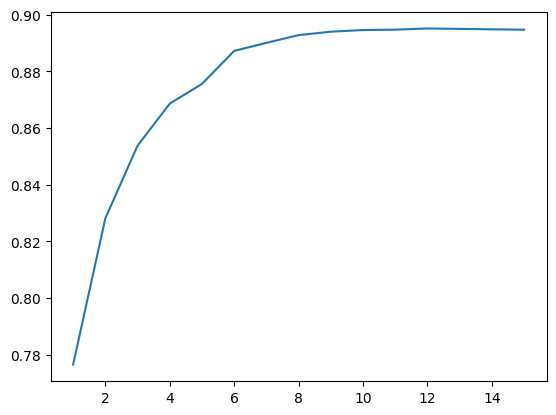

In [60]:
y_points = np.array(list(all_iterations['avg_score']))
x_points = np.array([i for i in range(1, len(y_points) + 1)])

plt.plot(x_points, y_points)